In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Normalization
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from keras_tuner import RandomSearch


In [4]:
data_df = pd.read_csv("https://raw.githubusercontent.com/Dhyanesh-Panchal/Music-genre-classification/master/final_processed_data.csv")
data_df.head()

,track_id,bit_rate,genre_top,file_path,rms_energy,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,...,spectral_contrast_mean,spectral_contrast_var,spectral_rolloff_mean,spectral_rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,chroma_features_mean,chroma_features_var,tonnetz_mean,tonnetz_var
0,2,256000,Hip-Hop,./fma_small/fma_small/000/000002.mp3,0.166016,-271.576050,1240.434200,167.950530,372.707600,-55.430290,...,13.805581,331.383750,6841.758957,6.364565e+06,0.017673,0.000197,0.682462,0.055268,0.022763,0.002430
1,5,256000,Hip-Hop,./fma_small/fma_small/000/000005.mp3,0.169584,-305.193359,1086.113892,162.682098,325.878754,-38.453510,...,13.539291,310.851663,5615.051326,6.584796e+06,0.010714,0.000098,0.755536,0.043002,0.004471,0.002592
2,10,192000,Pop,./fma_small/fma_small/000/000010.mp3,0.193821,-209.035233,897.279846,225.433670,171.503998,-51.170471,...,15.103988,319.583745,4999.788739,4.319190e+06,0.019142,0.000042,0.621837,0.051389,-0.031078,0.003304
3,140,128000,Folk,./fma_small/fma_small/000/000140.mp3,0.079091,-374.605194,4210.171387,159.731491,1262.999756,18.351295,...,17.168638,240.134141,3594.963309,9.010223e+06,0.009805,0.000215,0.746791,0.040860,0.011007,0.039335
4,141,128000,Folk,./fma_small/fma_small/000/000141.mp3,0.128064,-301.744232,6166.337402,190.034729,1789.849243,20.436043,...,17.593876,242.979064,3080.970647,4.090738e+06,0.012071,0.000163,0.603074,0.077434,-0.004314,0.034440


In [5]:
X = data_df.drop(["track_id","bit_rate","file_path","genre_top"],axis=1)
X
labels = data_df["genre_top"]
labels
encoder = LabelEncoder()
y = encoder.fit_transform(data_df["genre_top"])
y
# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X,dtype=float))
X

array([[-0.22556105,  0.66232508, -0.24735674, ...,  0.73574851,
         0.28277562, -0.8748421 ],
       [-0.1902815 ,  0.2551556 , -0.35957479, ...,  0.07034169,
        -0.22396258, -0.86565652],
       [ 0.04937689,  1.4198132 , -0.49689041, ...,  0.52533178,
        -1.20876913, -0.82539151],
       ...,
       [ 0.22338136,  0.08425503,  0.30805389, ..., -0.13155277,
         1.89916566,  1.17359093],
       [ 0.87982811,  0.47305632, -0.35577167, ..., -0.23223334,
        -0.3841122 , -0.10533523],
       [ 1.12474856,  1.96164311, -0.01113011, ...,  1.71384188,
        -0.35531745, -0.88705118]])

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape

(4310, 35)

In [8]:
def build(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(35,)))

    # Tune the number of hidden layers
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1)

    # Tune the width of each hidden layer
    for i in range(num_hidden_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=16)
        model.add(layers.Dense(units, activation='relu'))

    # Output layer
    model.add(layers.Dense(8, activation='softmax'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [11]:
tuner_search = RandomSearch(build,
                            objective = 'val_accuracy',
                            max_trials=5,
                            directory='tunner',
                            project_name='music_genre_classifier')

Reloading Tuner from tunner/music_genre_classifier/tuner0.json


In [12]:
# Search for the best hyperparameters
tuner_search.search(X_train, y_train, epochs=25, validation_split = 0.2)

best_model = tuner_search.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.4628770351409912

Best val_accuracy So Far: 0.5185614824295044
Total elapsed time: 00h 06m 41s


In [13]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 464)               16704     
                                                                 
 dense_1 (Dense)             (None, 32)                14880     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 35016 (136.78 KB)
Trainable params: 35016 

In [22]:
fitting = best_model.fit(X_train,y_train,epochs=500,validation_split=0.05)

Epoch 1/500
128/128 [==============================] - 1s 4ms/step - loss: 0.0892 - accuracy: 0.9717 - val_loss: 0.1588 - val_accuracy: 0.9722
Epoch 2/500
128/128 [==============================] - 0s 3ms/step - loss: 0.0441 - accuracy: 0.9902 - val_loss: 0.0974 - val_accuracy: 0.9722
Epoch 3/500
128/128 [==============================] - 0s 3ms/step - loss: 0.0175 - accuracy: 0.9971 - val_loss: 0.0863 - val_accuracy: 0.9815
Epoch 4/500
128/128 [==============================] - 0s 3ms/step - loss: 0.0067 - accuracy: 0.9993 - val_loss: 0.0715 - val_accuracy: 0.9861
Epoch 5/500
128/128 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0595 - val_accuracy: 0.9861
Epoch 6/500
128/128 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0563 - val_accuracy: 0.9861
Epoch 7/500
128/128 [==============================] - 0s 3ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0564 - val_accuracy: 0.9861

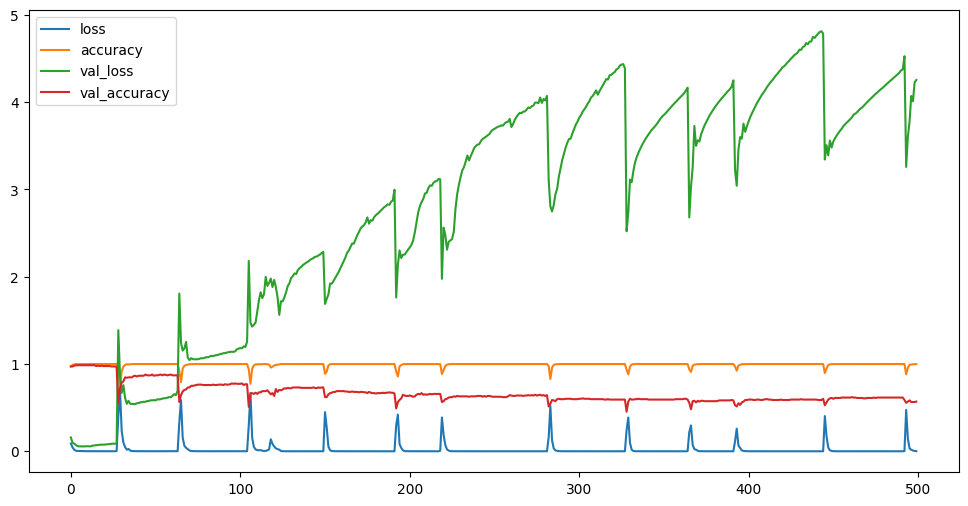

In [23]:
pd.DataFrame(fitting.history).plot(figsize=(12,6))
plt.show()

In [24]:
prediction = best_model.predict(X_test)
predicted_index = np.argmax(prediction, axis = 1)

34/34 [==============================] - 0s 2ms/step


In [25]:
import seaborn as sns

<Axes: >

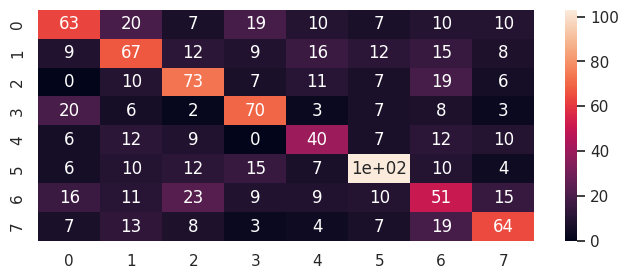

In [26]:
cf_matrix = confusion_matrix(y_test,predicted_index)
sns.set_theme(rc = {'figure.figsize':(8,3)})
sns.heatmap(cf_matrix, annot=True)